# 라이브러리 및 데이터 불러오기
## 필요 라이브러리

In [35]:
import itertools
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io.arff import loadarff
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import random
from matplotlib.collections import EllipseCollection
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Conv1D, ReLU, GlobalAveragePooling1D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## 데이터 불러오기

In [36]:
def read_file(file_path_url):  # 입력: 파일 경로(url)
    return np.loadtxt(file_path_url, delimiter='\t')

root_url = 'https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/'  # url root

train = read_file(root_url + 'FordA_TRAIN.tsv')
test = read_file(root_url + 'FordA_TEST.tsv')

In [37]:
print('train_set.shape:', train.shape)
print('test_set.shape:', test.shape)

train_set.shape: (3601, 501)
test_set.shape: (1320, 501)


### 입력 변수(x), 타겟 변수(y) 분리하기

In [38]:
x_train_temp = train[:, 1:]
y_train_temp = train[:, 0]  # 첫 번째 column이 Label 값이 있는 column
X_test = test[:, 1:]
y_test = test[:, 0]  # 첫 번째 column이 label 값이 있는 column

### 학습용, 검증용, 테스트용 데이터 세트 분리

In [39]:
x_normal = x_train_temp[y_train_temp==1]  # X_train 데이터 중 정상 데이터
x_abnormal = x_train_temp[y_train_temp==-1]  # X_train 데이터 중 비정상 데이터
y_normal = y_train_temp[y_train_temp==1]  # y_train 데이터 중 정상 데이터
y_abnormal = y_train_temp[y_train_temp==-1]  # y_train 데이터 중 비정상 데이터

ind_x_normal = int(x_normal.shape[0] * 0.8)  # 정상 데이터를 8:2로 나누기 위한 기준 인덱스 설정
ind_y_normal = int(y_normal.shape[0] * 0.8)  # 정상 데이터를 8:2로 나누기 위한 기준 인덱스 설정
ind_x_abnormal = int(x_abnormal.shape[0] * 0.8)  # 비정상 데이터를 8:2로 나누기 위한 기준 인덱스 설정
ind_y_abnormal = int(y_abnormal.shape[0] * 0.8)  # 비정상 데이터를 8:2로 나누기 위한 기준 인덱스 설정

X_train = np.concatenate((x_normal[:ind_x_normal], x_abnormal[:ind_x_abnormal]), axis=0)
X_valid = np.concatenate((x_normal[ind_x_normal:], x_abnormal[ind_x_abnormal:]), axis=0)
y_train = np.concatenate((y_normal[:ind_y_normal], y_abnormal[:ind_y_abnormal]), axis=0)
y_valid = np.concatenate((y_normal[ind_y_normal:], y_abnormal[ind_y_abnormal:]), axis=0)

In [40]:
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2880, 500)
X_valid shape: (721, 500)
y_train shape: (2880,)
y_valid shape: (721,)
X_test shape: (1320, 500)
y_test shape: (1320,)


# 데이터 시각화
## 시각화 I: 데이터 불균형 확인

<Figure size 800x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Training Data')

<BarContainer object of 2 artists>

(0.0, 1500.0)

([<matplotlib.axis.XTick at 0x1a64d2b4a50>,
 [Text(0, 0, 'Abnormal'), Text(1, 0, 'Normal')])

<Axes: >

Text(0.5, 1.0, 'Validation Data')

<BarContainer object of 2 artists>

(0.0, 1500.0)

([<matplotlib.axis.XTick at 0x1a6600b7a50>,
 [Text(0, 0, 'Abnormal'), Text(1, 0, 'Normal')])

<Axes: >

Text(0.5, 1.0, 'Test Data')

<BarContainer object of 2 artists>

(0.0, 1500.0)

([<matplotlib.axis.XTick at 0x1a65804d850>,
 [Text(0, 0, 'Abnormal'), Text(1, 0, 'Normal')])

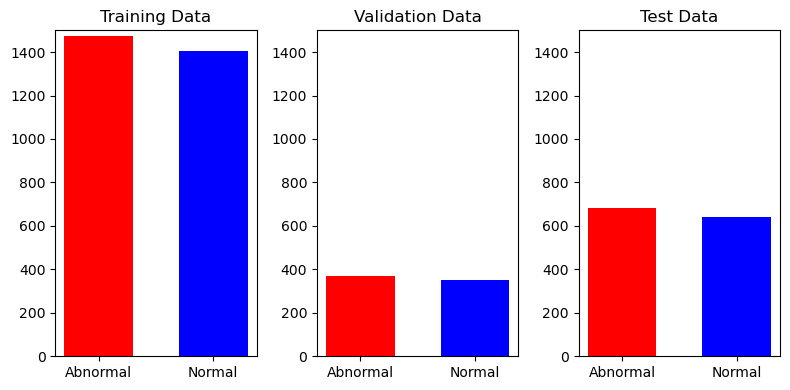

In [41]:
save_path = './datasets/FordEngine/'

# class의 종류 확인: 정상 1, 비정상 -1
classes = np.unique(np.concatenate((y_train, y_test), axis=0))  # classes = array([-1, 1])

x = np.arange(len(classes))  # plot의 x축의 개수 구하기
labels = ['Abnormal', 'Normal']  # plot의 x축의 이름 구하기

values_train = [(y_train == i).sum() for i in classes]  # Train 데이터의 정상/비정상 각 총 개수
values_valid = [(y_valid == i).sum() for i in classes]  # Valid 데이터의 정상/비정상 각 총 개수
values_test = [(y_test == i).sum() for i in classes]  # Test 데이터의 정상/비정상 각 총 개수

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.title('Training Data')
plt.bar(x, values_train, width=0.6, color=['red', 'blue'])  # Train 데이터의 정상 / 비정상 개수
plt.ylim([0, 1500])
plt.xticks(x, labels)  # x축에 변수 기입

plt.subplot(1, 3, 2)
plt.title('Validation Data')
plt.bar(x, values_valid, width=0.6, color=['red', 'blue'])  # Valid 데이터의 정상 / 비정상 개수
plt.ylim([0, 1500])
plt.xticks(x, labels)

plt.subplot(1, 3, 3)
plt.title('Test Data')
plt.bar(x, values_test, width=0.6, color=['red', 'blue'])  # Test 데이터의 정상 / 비정상 개수
plt.ylim([0, 1500])
plt.xticks(x, labels)

plt.tight_layout()
plt.show()

## 시각화 II-1: 특정 시간에서의 시계열 샘플을 플롯

<Figure size 1000x400 with 0 Axes>

Text(0.5, 0, 'Sensor')

Text(0, 0.5, 'Sensor Value')

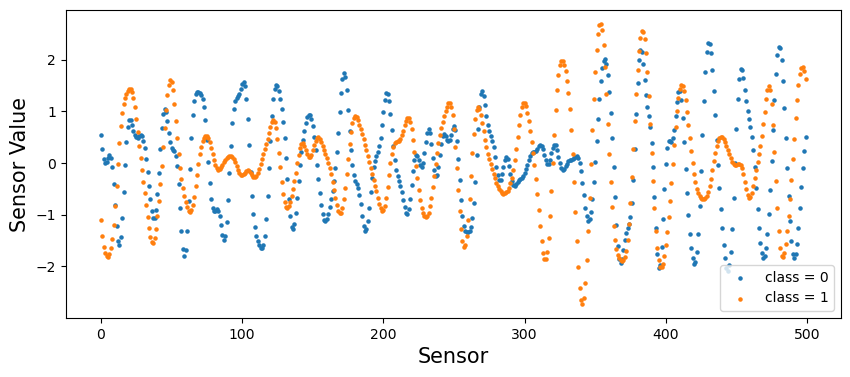

In [42]:
labels = np.unique(np.concatenate((y_train, y_test), axis=0))  # labels (-1 or 1)

plt.figure(figsize=(10, 4))

for c in labels:
    c_x_train = X_train[y_train == c]
    if c == -1:
        c = c + 1  # 편의상 Abnormal Class(-1)를 0으로 조정
    time_t = random.randint(0, c_x_train.shape[0])  # 0~1404 사이의 랜덤한 정수가 특정 time t가 됨
    plt.scatter(range(0, 500), c_x_train[time_t], label='class = '+str(int(c)), marker='o', s=5)
        
plt.legend(loc='lower right')
plt.xlabel('Sensor', fontsize=15)
plt.ylabel('Sensor Value', fontsize=15)
plt.show()

## 시각화 II-2: 특정 시간에서의 시계열 샘플을 플롯 (정상/비정상 샘플 각각 출력)

비정상 Label 데이터 수: 1476


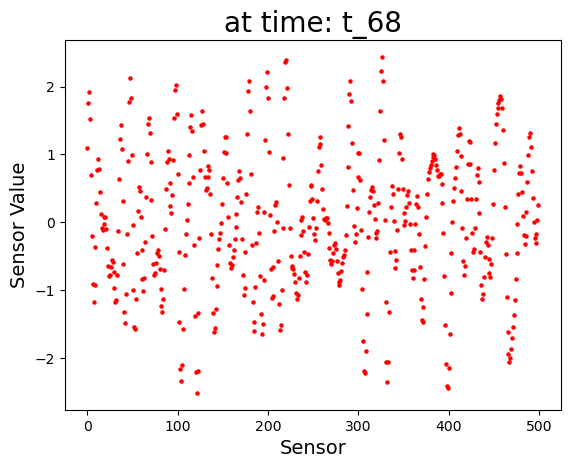

정상 Label 데이터 수: 1404


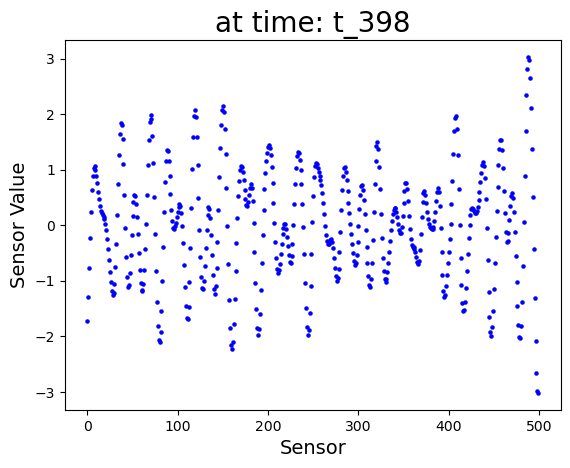

In [43]:
def get_scatter_plot(c):
    time_t = random.randint(0, c_x_train.shape[0])  # 0~1404 사이 랜덤한 정수가 특정 time t가 됨
    plt.scatter(range(0, c_x_train.shape[1]), c_x_train[time_t],
                marker='o', s=5, c='r' if c == -1 else 'b')
    plt.title('at time: t_{}'.format(time_t), fontsize=20)
    plt.xlabel('Sensor', fontsize=14)
    plt.ylabel('Sensor Value', fontsize=14)
    plt.show()
    
labels = np.unique(np.concatenate((y_train, y_test), axis=0))

for c in labels:
    c_x_train = X_train[y_train == c]
    if c == -1:
        print('비정상 Label 데이터 수:', len(c_x_train))
        get_scatter_plot(c)
    else:
        print('정상 Label 데이터 수:', len(c_x_train))
        get_scatter_plot(c)

## 시각화 III: 1개의 임의의 센서 값의 시계열 샘플을 플롯

<Figure size 1300x400 with 0 Axes>

Text(0.5, 1.0, 'sensor_number: 226')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Sensor Value')

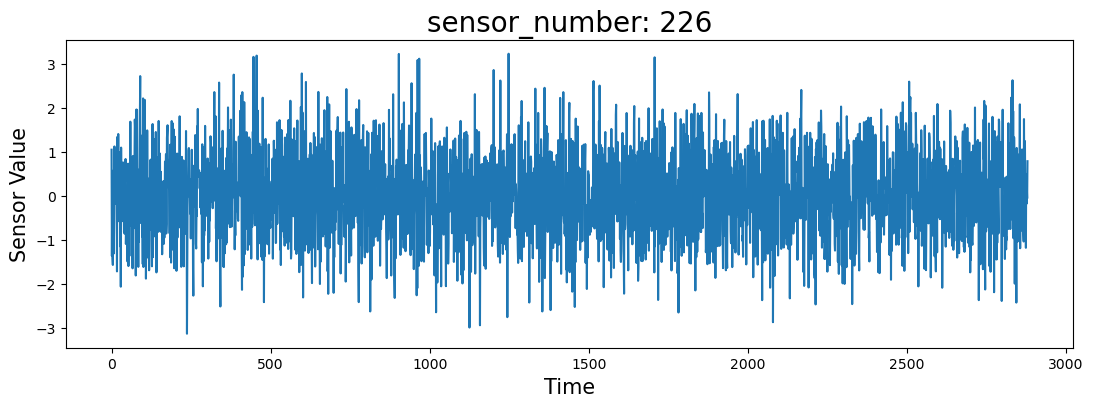

In [44]:
sensor_number = random.randint(0, 500)  # 0~500 사이 랜덤한 정수가 Sensor 번호가 됨
plt.figure(figsize=(13, 4))
plt.title('sensor_number: {}'.format(sensor_number), fontsize=20)
plt.plot(X_train[:, sensor_number])
plt.xlabel('Time', fontsize=15)
plt.ylabel('Sensor Value', fontsize=15)
plt.show()

# 데이터 특성 파악
## 상관관계 분석

Text(0.5, 1.0, 'Correlation between Feature')

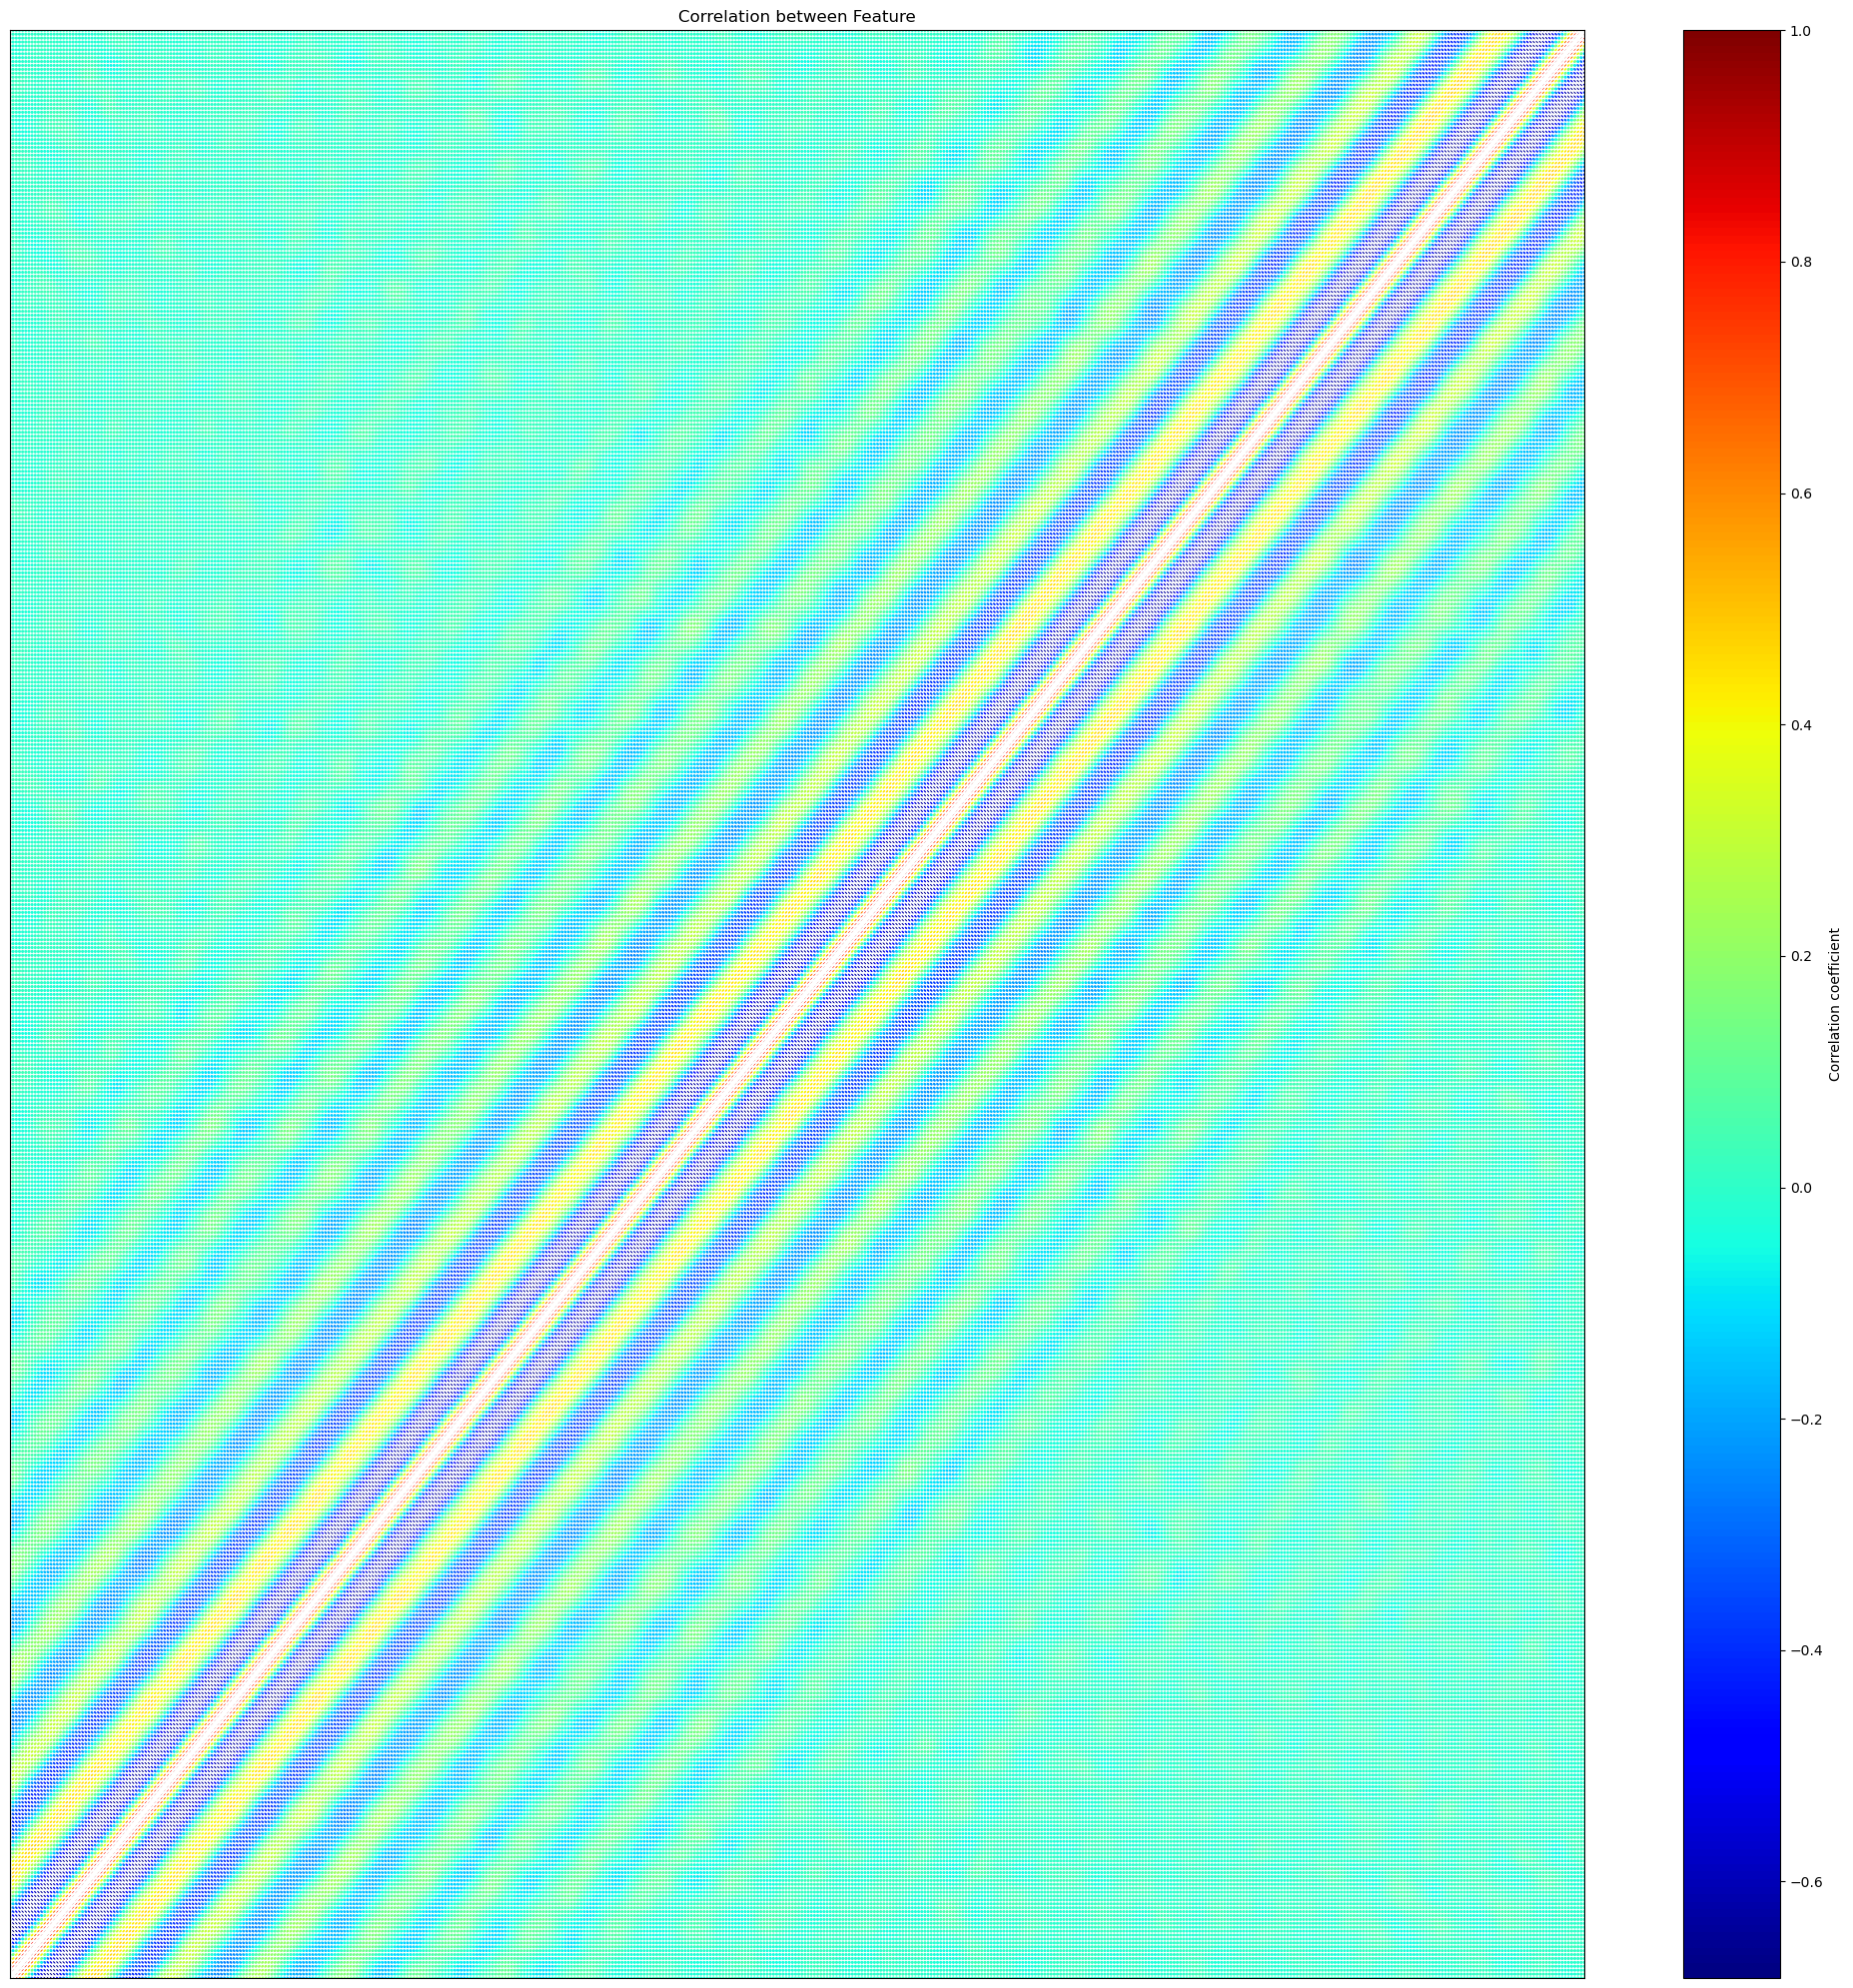

In [45]:
df = pd.DataFrame(data= X_train,
                  columns= ['sensor_{}'.format(label+1) for label in range(X_train.shape[1])])
data = df.corr()

def plot_corr_ellipses(data, ax = None, **kwargs):
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[0] - 0.5)
        ax.set_ylim(-0.5, M.shape[1] - 0.5)
        
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T
        
    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)
    return ec
    
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
cmap = plt.cm.jet
m = plot_corr_ellipses(data, ax=ax, cmap=cmap)
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')
plt.title('Correlation between Feature')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

# 데이터 전처리
## 데이터 정규화

In [46]:
# Robust Scaler 
rscaler = RobustScaler()
rscaler.fit(X_train)
X_train = rscaler.transform(X_train)
X_valid = rscaler.transform(X_valid)

RobustScaler()

## 데이터 형태 변환
- CNN, RNN 모델 적용 시 텐서의 형태를 2D에서 3D로 바꿔 준 입력 인풋 사용

  -> 본 시계열 데이터가 다변량(Multivariate)이며, 1개의 채널(Channel)만 갖는 점이 있기 때문에 데이터 형태를 변경

In [47]:
# CNN, RNN 모델의 입력 변수는 채널 축 1개 차원을 확장시킨 3D Tensor
# 아래 CNN, RNN 모델은 X_train, X_valid, X_test를 입력 변수로 넣지 않고,
# X_train_exp, X_valid_exp, X_test_exp를 넣음

# X_train_exp = np.expand_dims(X_train, -1)  # 채널 축 1개 차원을 확장시킨(Expand) X_train
# 아래와 동일한 역할 수행 코드
X_train_exp = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_exp = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_exp = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('X_train_exp의 형태:', X_train_exp.shape)
print('X_valid_exp의 형태:', X_valid_exp.shape)
print('X_test_exp의 형태:', X_test_exp.shape)

X_train_exp의 형태: (2880, 500, 1)
X_valid_exp의 형태: (721, 500, 1)
X_test_exp의 형태: (1320, 500, 1)


## 종속 변수(y)를 양의 값으로 변경
- 모델 학습을 위해 종속 변수인 Label(비정상: -1 또는 정상: 1) 값을 양의 값으로 바꿈

In [48]:
y_train[y_train == -1] = 0
y_valid[y_valid == -1] = 0
y_test[y_test == -1] = 0

# 모델 구축 및 설계
## 순환 신경망(Recurrent Neural Network)
- LSTM을 사용, LSTM은 RNN 계열의 모델 중 하나로, RNN이 숨겨진 상태(hidden state)에 셀 상태(cell-state)를 추가한 구조

### 과적합 처리(모델 추가) 및 l2 규제 추가
- dropout 층 추가, l2 규제 추가

In [49]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

def make_rnn_model_drout():
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.25))  
    model.add(LSTM(units=32, return_sequences=True))  
    model.add(Dropout(0.25))  
    model.add(Flatten())                   # l2 규제 추가
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  
    model.add(Dense(2, activation='softmax'))
    return model

rnn_model_drout = make_rnn_model_drout()

epochs = 100
batch_size = 32
rnn_model_drout.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['sparse_categorical_accuracy']
                 )
callbacks = [ModelCheckpoint(save_path + 'rnn_best_model5.keras',
                             monitor='val_loss',
                             save_best_only=True),
             ReduceLROnPlateau(
                 monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001),
             EarlyStopping(monitor='val_loss', patience=10, verbose=1)]

history_rnn_drout = rnn_model_drout.fit(
    X_train_exp,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_valid_exp, y_valid),
    verbose=1
)

Epoch 1/100
90/90 [==============================] - 69s 510ms/step - loss: 0.9010 - sparse_categorical_accuracy: 0.5806 - val_loss: 0.7368 - val_sparse_categorical_accuracy: 0.6796 - lr: 0.0010
Epoch 2/100
90/90 [==============================] - 38s 425ms/step - loss: 0.7613 - sparse_categorical_accuracy: 0.6399 - val_loss: 0.7241 - val_sparse_categorical_accuracy: 0.6727 - lr: 0.0010
Epoch 3/100
90/90 [==============================] - 38s 426ms/step - loss: 0.7395 - sparse_categorical_accuracy: 0.6608 - val_loss: 0.7367 - val_sparse_categorical_accuracy: 0.6921 - lr: 0.0010
Epoch 4/100
90/90 [==============================] - 38s 425ms/step - loss: 0.7485 - sparse_categorical_accuracy: 0.7014 - val_loss: 0.7761 - val_sparse_categorical_accuracy: 0.7171 - lr: 0.0010
Epoch 5/100
90/90 [==============================] - 39s 431ms/step - loss: 0.7234 - sparse_categorical_accuracy: 0.7337 - val_loss: 0.6793 - val_sparse_categorical_accuracy: 0.7670 - lr: 0.0010
Epoch 6/100
90/90 [======

Epoch 43/100
90/90 [==============================] - 39s 431ms/step - loss: 0.2747 - sparse_categorical_accuracy: 0.9424 - val_loss: 0.3176 - val_sparse_categorical_accuracy: 0.9320 - lr: 0.0010
Epoch 43: early stopping


# 모델 평가

In [50]:
# 과적합 처리(모델 추가), l2 규제 추가
rnn_model_drout =  tf.keras.models.load_model(save_path + 'rnn_best_model5.keras')
scores_d = rnn_model_drout.evaluate(X_test_exp, y_test)
print('\n''Test accuracy', scores_d[1])
print('\n''Test loss', scores_d[0])
print('%s: %.2f%%' % (rnn_model_drout.metrics_names[1], scores_d[1]*100))

42/42 [==============================] - 20s 180ms/step - loss: 0.3065 - sparse_categorical_accuracy: 0.9295

Test accuracy 0.9295454621315002

Test loss 0.3065466284751892
sparse_categorical_accuracy: 92.95%


# 결과 분석 및 해석
- 공통 분석 방법:
  - 혼동 행렬
  - ROC Curve
  - Learning Curve
  - 학습 과정 중 정확도 추이
  - 손실(Loss) 추이
## 결과 시각화 함수 정의
### 혼동 행렬(Confusion Matrix)

In [51]:
def draw_confusion_matrix(model, xt, yt, model_name):
    Y_pred = model.predict(xt)
    
    if model_name in ['rnn']:
        y_pred = np.argmax(Y_pred, axis=1)
    else: y_pred = Y_pred
        
    plt.figure(figsize=(3, 3))
    cm = confusion_matrix(yt, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['False', 'True'], rotation=45)
    plt.yticks(tick_marks, ['False', 'True'])
    thresh = cm.max()/1.2
    normalize = False
    
    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment = 'center',
                    color = 'white' if cm[i, j] > thresh else 'black',
                    fontsize=12)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(save_path + '{}_cm2.png'.format(model_name), dpi=100, bbox_inches='tight')
    plt.show()
    
    print(classification_report(yt, y_pred))

### ROC Curve
- ROC Curve는 좌상단에 붙어 있는 커브가 더 좋은 분류기를 의미

In [52]:
def draw_roc(model, xt, yt, model_name):
    Y_pred = model.predict(xt)
    
    if model_name in ['rnn']:
        y_pred = np.argmax(Y_pred, axis=1)
    else: y_pred = Y_pred
        
    fpr, tpr, thr = roc_curve(yt, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC Curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format(model_name))
    plt.legend(loc='lower right')
    plt.ion()
    plt.tight_layout()
    plt.savefig(save_path + '{}_roc2.png'.format(model_name), dpi=100, bbox_inches='tight')
    plt.show()

### Epoch에 따른 학습 & 검증의 손실(loss) 그래프

In [53]:
def plot_loss_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training & Validation Loss')
    plt.xlabel('epoch', fontsize='large')
    plt.ylabel('loss', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(save_path + '{}_2.png'.format(pic_name), dpi=100, bbox_inches='tight')
    plt.show()

### Epoch에 따른 정확도(Accuracy Rate) 그래프

In [54]:
def plot_prediction_graph(history, pic_name):
    plt.figure()
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_' + 'sparse_categorical_accuracy'])
    plt.title('model ' + 'Prediction Accuracy')
    plt.xlabel('epoch', fontsize='large')
    plt.ylabel('sparse_categorical_accuracy', fontsize='large')
    plt.legend(['train', 'validation'], loc='best')
    plt.tight_layout()
    plt.savefig(save_path + '{}_2.png'.format(pic_name), dpi=100, bbox_inches='tight')
    plt.show()

## 결과 분석 및 해석 - 순환 신경망(RNN)
### 혼동 행렬

42/42 [==============================] - 14s 177ms/step


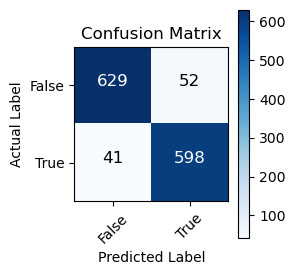

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       681
         1.0       0.92      0.94      0.93       639

    accuracy                           0.93      1320
   macro avg       0.93      0.93      0.93      1320
weighted avg       0.93      0.93      0.93      1320



In [55]:
draw_confusion_matrix(rnn_model_drout, X_test_exp, y_test, 'rnn')

### ROC Curve
- ROC Curve는 좌상단에 붙어 있는 커브가 더 좋은 분류기를 의미

42/42 [==============================] - 8s 184ms/step


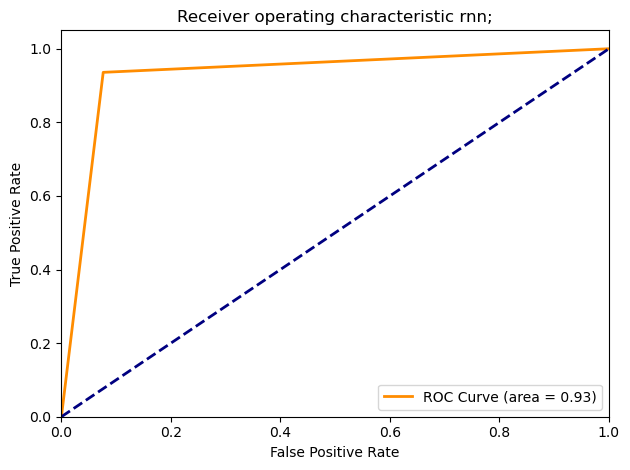

In [56]:
draw_roc(rnn_model_drout, X_test_exp, y_test, 'rnn')

### Learning Curve: Epoch에 따른 학습, 검증 손실(Loss) 추이

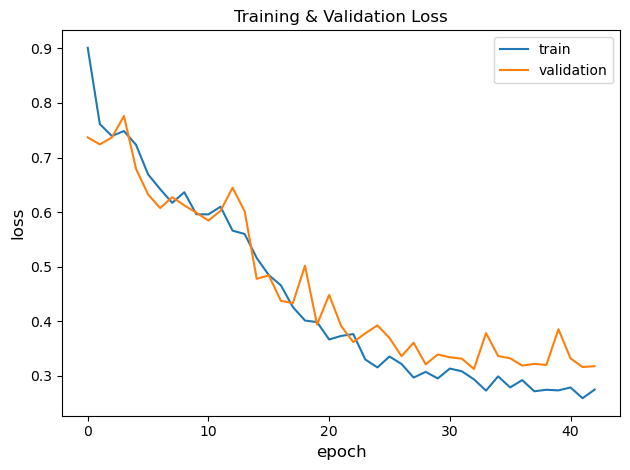

In [57]:
plot_loss_graph(history_rnn_drout, 'rnn')

### Learning Curve: Epoch에 따른 학습, 검증 정확도 추이

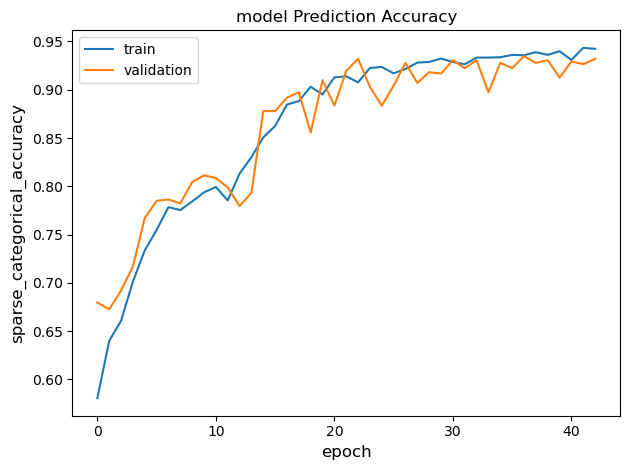

In [58]:
plot_prediction_graph(history_rnn_drout, 'rnn')